DISTILBERT SENTIMENT ANALYSE

In [ ]:
#!pip install --upgrade pip setuptools wheel
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install transformers pandas matplotlib

In [1]:
#Load resources
import pandas as pd
from transformers import pipeline

In [2]:
#load data
data = pd.read_csv('/content/sample_data/Comb_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10134 entries, 0 to 10133
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10134 non-null  object 
 1   name            10134 non-null  object 
 2   brand           10134 non-null  object 
 3   reviews.date    10125 non-null  object 
 4   reviews.rating  10111 non-null  float64
 5   reviews.text    10133 non-null  object 
 6   reviews.title   10132 non-null  object 
dtypes: float64(1), object(6)
memory usage: 554.3+ KB


In [3]:
## Model selection

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [4]:
texts = data["reviews.text"].fillna("").astype(str).tolist()


In [5]:
# start small first (fast)
results = sentiment_pipe(texts[:200], batch_size=32, truncation=True)

data.loc[:len(results)-1, "bert_sentiment"] = [r["label"] for r in results]
data.loc[:len(results)-1, "bert_score"] = [r["score"] for r in results]

data[["reviews.text", "bert_sentiment", "bert_score"]].head(10)

,reviews.text,bert_sentiment,bert_score
0,This product so far has not disappointed. My c...,POSITIVE,0.999668
1,great for beginner or experienced person. Boug...,POSITIVE,0.999852
2,Inexpensive tablet for him to use and learn on...,POSITIVE,0.997491
3,I've had my Fire HD 8 two weeks now and I love...,POSITIVE,0.999776
4,I bought this for my grand daughter when she c...,POSITIVE,0.995453
5,This amazon fire 8 inch tablet is the perfect ...,POSITIVE,0.997538
6,"Great for e-reading on the go, nice and light ...",POSITIVE,0.999854
7,"I gave this as a Christmas gift to my inlaws, ...",POSITIVE,0.999878
8,Great as a device to read books. I like that i...,POSITIVE,0.999606
9,I love ordering books and reading them with th...,POSITIVE,0.999474


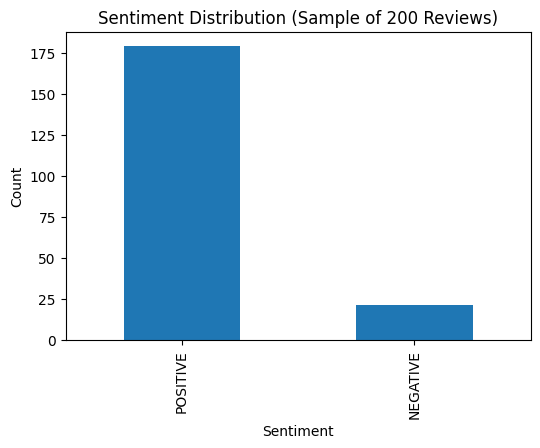

In [6]:
# Plot the sentiment distribution (for the sample)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data["bert_sentiment"][:200].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution (Sample of 200 Reviews)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [7]:
## Create sentiment labels from ratings:

def rating_to_sentiment(rating):
    if rating >= 4:
        return 1   # positive
    elif rating == 3:
        return 0   # neutral (optional)
    else:
        return -1  # negative

data["sentiment"] = data["reviews.rating"].apply(rating_to_sentiment)



In [8]:
print(data.columns)

Index(['id', 'name', 'brand', 'reviews.date', 'reviews.rating', 'reviews.text',
       'reviews.title', 'bert_sentiment', 'bert_score', 'sentiment'],
      dtype='object')


In [8]:
## Keeping only needed columnn:

data = data[["reviews.text", "sentiment"]].dropna()
data = data.rename(columns={"reviews.text": "text"})

In [9]:
## Splitting data into train and test sets:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["sentiment"]) #keeping class balance

#Check sizes:
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Train set size: 8106
Test set size: 2027


In [11]:
## Converting to Hugging Face Datasets format:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data.reset_index(drop=True))

In [12]:
## SAnity check:
print(train_dataset[0])

{'text': 'great purchase very pleased with our tablet!!!!!!!', 'sentiment': 1}


In [13]:
## Tokenizing the data with DistilBERT tokenizer:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(data):
    return tokenizer(data["text"],
        padding="max_length",
        truncation=True)

In [14]:
## Load DistilBERT for training

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [17]:
#Redifinig labels:
data["label"] = data["sentiment"].map({-1: 0, 0: 1, 1: 2})
data = data[["text", "label"]]

In [18]:
## Data collator (to save RAM vs padding)
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
## Tokenizing the data with DistilBERT tokenizer:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(data):
    return tokenizer(data["text"],
        padding="max_length",
        truncation=True)

train_tok = train_dataset.map(tokenize_function, batched=True)
test_tok = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8106 [00:00<?, ? examples/s]

Map:   0%|          | 0/2027 [00:00<?, ? examples/s]

In [24]:
## Tokenizing the data with DistilBERT tokenizer:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(data):
    return tokenizer(data["text"],
        padding="max_length",
        truncation=True)

# Re-split data, which now has 'text' and 'label' after cell X8HkhAXAqYWh
from sklearn.model_selection import train_test_split

# Use the 'data' DataFrame which now contains the 'label' column
train_data_df, test_data_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data["label"])

# Convert to Hugging Face Datasets format
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data_df.reset_index(drop=True))

# Rename 'label' column to 'labels' as expected by the Trainer
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_tok = train_dataset.map(tokenize_function, batched=True)
test_tok = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/8106 [00:00<?, ? examples/s]

Map:   0%|          | 0/2027 [00:00<?, ? examples/s]

In [25]:
## Train wth trainer
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

#defining arguments
training_args = TrainingArguments(
    output_dir="./distilbert_reviews",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

#training
trainer.train()

#evaluate
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.222000,0.232616,0.928959,0.528178
2,0.195630,0.263787,0.928466,0.569115
3,0.178329,0.265239,0.927972,0.614658


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'eval_loss': 0.265239417552948,
 'eval_accuracy': 0.9279723729649728,
 'eval_f1': 0.6146577229426073,
 'eval_runtime': 36.4436,
 'eval_samples_per_second': 55.62,
 'eval_steps_per_second': 3.485,
 'epoch': 3.0}

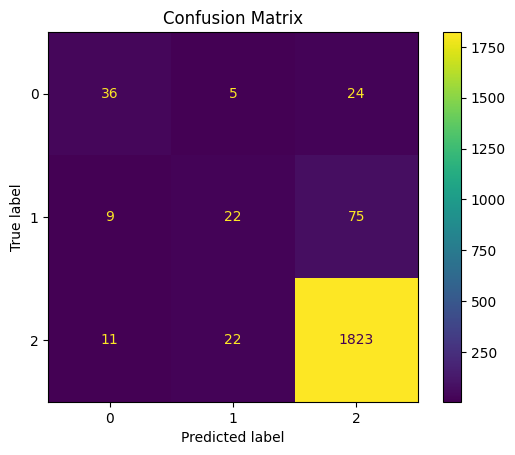

In [28]:
## confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(test_tok)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ["Negative", "Neutral", "Positive"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Confusion Matrix")
plt.show()
